In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pathlib import Path
import pandas as pd
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from synapse.ml.lightgbm import *

pio.renderers.default = "iframe"

In [2]:
# base_path = "/data/saturation/central_composite_design/ccd6"
# base_path_holdout = "/data/saturation/central_composite_design/ccd6_holdout_larger"

base_path = "/data/saturation/central_composite_design/ccd9"
base_path_holdout = "/data/saturation/central_composite_design/ccd9_holdout"

ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"] #, "n_craters_in_study_region"]

In [3]:
# train_df = pd.read_csv(f"{base_path}/post_saturation_sample_100.csv")
# train_df = pd.read_csv(f"{base_path}/post_saturation_sample_500.csv")
train_df = pd.read_csv(f"{base_path}/post_saturation_sample_5000.csv")

# test_df = pd.read_csv(f"{base_path_holdout}/post_saturation_sample_100.csv")
# test_df = pd.read_csv(f"{base_path_holdout}/post_saturation_sample_500.csv")
test_df = pd.read_csv(f"{base_path_holdout}/post_saturation_sample_5000.csv")

metric = "n_craters_in_study_region"

In [4]:
n_cores = 28

spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "48g") \
                    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.10.2") \
                    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                    .getOrCreate()
sc = spark.sparkContext

23/05/04 15:33:05 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
23/05/04 15:33:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/mason/code/saturation/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/mason/.ivy2/cache
The jars for the packages stored in: /home/mason/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-641573dc-a6f6-4b6a-b540-4c892476526e;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;0.10.2 in central
	found com.microsoft.azure#synapseml-core_2.12;0.10.2 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in cen

23/05/04 15:33:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/04 15:33:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### LightGBM models

#### Baseline Model

In [5]:
def score_model(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 1):
    sampled = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    y = sampled[metric]
    
    X = poly_transform.transform(sampled[ivs])
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
    
    df_spark = spark.createDataFrame(X)
    spark_X = assembler.transform(df_spark)[["features"]]
    predictions = model.transform(spark_X).toPandas()["prediction"]

    pred_df = pd.concat([X, predictions], axis=1)
    pred_df["actual"] = y.reset_index(drop=True)
    pred_df["n_craters"] = list(sampled.index)
    
    return pred_df


def plot_sim_ci(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 250):   
    # Show params
    print(f"Simulation parameters: {df[ivs].iloc[0]}")
    
    ns_max = 100000
    plt.plot(df.n_craters_added_in_study_region.iloc[:ns_max],
             df[metric].iloc[:ns_max])
    plt.xlabel("$N_S$")
    plt.ylabel("$A_d$")
    plt.show()

    pred_df = score_model(model, df, metric, assembler, ivs, features, sample_cadence)
   
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["prediction"],
                    mode="lines",
                    name="95% Threshold")

    fig.update_layout(
        xaxis_title="$N_S$",
        yaxis_title=metric
    )

    fig.show()

In [6]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=ivs,
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.05)
    .setLearningRate(0.3)
    .setNumIterations(5)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(ivs, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

23/05/04 15:35:29 WARN TaskSetManager: Stage 1 contains a task of very large size (14277 KiB). The maximum recommended task size is 1000 KiB.


23/05/04 15:35:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 28): Attempting to kill Python Worker
23/05/04 15:35:34 WARN TaskSetManager: Stage 2 contains a task of very large size (14277 KiB). The maximum recommended task size is 1000 KiB.


23/05/04 15:37:40 WARN TaskSetManager: Stage 3 contains a task of very large size (13195 KiB). The maximum recommended task size is 1000 KiB.


Training % outside of range: 0.027
23/05/04 15:40:09 WARN TaskSetManager: Stage 4 contains a task of very large size (5273 KiB). The maximum recommended task size is 1000 KiB.


Testing % outside of range: 0.002
Feature importances:
   effective_radius_multiplier: 13.0
   slope: 7.0
   r_stat_multiplier: 0.0
   min_rim_percentage: 0.0


In [7]:
# More iterations

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=ivs,
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.05)
    .setLearningRate(0.3)
    .setNumIterations(100)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(ivs, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

23/05/04 15:43:06 WARN TaskSetManager: Stage 6 contains a task of very large size (14277 KiB). The maximum recommended task size is 1000 KiB.


23/05/04 15:43:10 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6 (TID 141): Attempting to kill Python Worker
23/05/04 15:43:10 WARN TaskSetManager: Stage 7 contains a task of very large size (14277 KiB). The maximum recommended task size is 1000 KiB.


23/05/04 15:45:19 WARN TaskSetManager: Stage 8 contains a task of very large size (13195 KiB). The maximum recommended task size is 1000 KiB.


Training % outside of range: 0.049
23/05/04 15:47:47 WARN TaskSetManager: Stage 9 contains a task of very large size (5273 KiB). The maximum recommended task size is 1000 KiB.


Testing % outside of range: 0.162
Feature importances:
   slope: 167.0
   effective_radius_multiplier: 126.0
   min_rim_percentage: 97.0
   r_stat_multiplier: 10.0


In [8]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.05)
    .setLearningRate(0.3)
    .setNumIterations(50)
    .setNumLeaves(10)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(poly_transform.get_feature_names_out(), model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

23/05/04 15:54:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/04 15:54:01 WARN TaskSetManager: Stage 11 contains a task of very large size (44703 KiB). The maximum recommended task size is 1000 KiB.


23/05/04 15:54:05 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 11 (TID 254): Attempting to kill Python Worker
23/05/04 15:54:05 WARN TaskSetManager: Stage 12 contains a task of very large size (44703 KiB). The maximum recommended task size is 1000 KiB.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


23/05/04 15:59:37 WARN TaskSetManager: Stage 13 contains a task of very large size (43621 KiB). The maximum recommended task size is 1000 KiB.


Training % outside of range: 0.047
23/05/04 16:03:22 WARN TaskSetManager: Stage 14 contains a task of very large size (17425 KiB). The maximum recommended task size is 1000 KiB.


Testing % outside of range: 0.268
Feature importances:
   slope: 140.0
   effective_radius_multiplier: 97.0
   effective_radius_multiplier min_rim_percentage: 81.0
   slope effective_radius_multiplier: 43.0
   min_rim_percentage: 25.0
   slope min_rim_percentage: 25.0
   r_stat_multiplier: 12.0
   effective_radius_multiplier r_stat_multiplier: 10.0
   r_stat_multiplier min_rim_percentage: 10.0
   slope r_stat_multiplier: 7.0
   slope^2: 0.0
   effective_radius_multiplier^2: 0.0
   r_stat_multiplier^2: 0.0
   min_rim_percentage^2: 0.0


### Plotting thresholds

In [9]:
# Load up a subset of the test DFs
np.random.seed(123)

paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))
choices = set(np.random.choice(len(paths), 100))

holdout_dfs = [pd.read_parquet(x) for idx, x in enumerate(paths) if idx in choices]

In [10]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"]

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.05)
    .setLearningRate(0.3)
    .setNumIterations(50)
    .setNumLeaves(10)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(poly_transform.get_feature_names_out(), model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

23/05/04 16:09:42 WARN TaskSetManager: Stage 16 contains a task of very large size (44703 KiB). The maximum recommended task size is 1000 KiB.


23/05/04 16:09:46 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 16 (TID 367): Attempting to kill Python Worker
23/05/04 16:09:46 WARN TaskSetManager: Stage 17 contains a task of very large size (44703 KiB). The maximum recommended task size is 1000 KiB.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


23/05/04 16:15:17 WARN TaskSetManager: Stage 18 contains a task of very large size (43621 KiB). The maximum recommended task size is 1000 KiB.


Training % outside of range: 0.047
23/05/04 16:19:05 WARN TaskSetManager: Stage 19 contains a task of very large size (17425 KiB). The maximum recommended task size is 1000 KiB.


Testing % outside of range: 0.268
Feature importances:
   slope: 140.0
   effective_radius_multiplier: 97.0
   effective_radius_multiplier min_rim_percentage: 81.0
   slope effective_radius_multiplier: 43.0
   min_rim_percentage: 25.0
   slope min_rim_percentage: 25.0
   r_stat_multiplier: 12.0
   effective_radius_multiplier r_stat_multiplier: 10.0
   r_stat_multiplier min_rim_percentage: 10.0
   slope r_stat_multiplier: 7.0
   slope^2: 0.0
   effective_radius_multiplier^2: 0.0
   r_stat_multiplier^2: 0.0
   min_rim_percentage^2: 0.0


Simulation parameters: slope                          1.207184
effective_radius_multiplier    1.583289
r_stat_multiplier              8.533556
min_rim_percentage             0.551948
Name: 0, dtype: float64


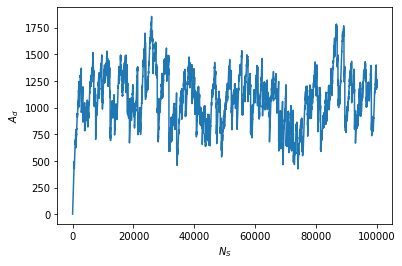

Simulation parameters: slope                          1.732103
effective_radius_multiplier    1.750466
r_stat_multiplier              8.500973
min_rim_percentage             0.352938
Name: 0, dtype: float64


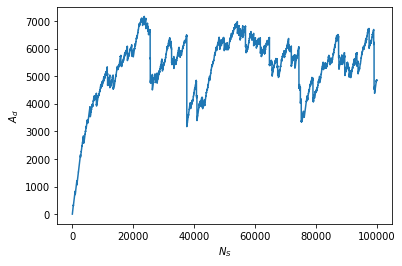

Simulation parameters: slope                          1.200000
effective_radius_multiplier    1.416667
r_stat_multiplier              3.500000
min_rim_percentage             0.350000
Name: 0, dtype: float64


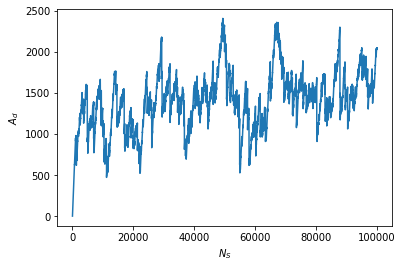

Simulation parameters: slope                          1.202794
effective_radius_multiplier    1.250476
r_stat_multiplier              6.829366
min_rim_percentage             0.548702
Name: 0, dtype: float64


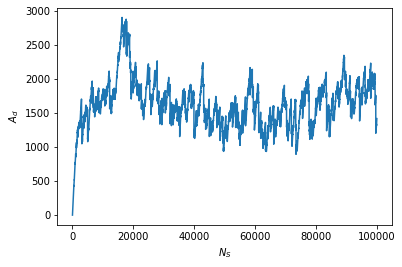

Simulation parameters: slope                          1.733333
effective_radius_multiplier    1.583333
r_stat_multiplier              8.500000
min_rim_percentage             0.450000
Name: 0, dtype: float64


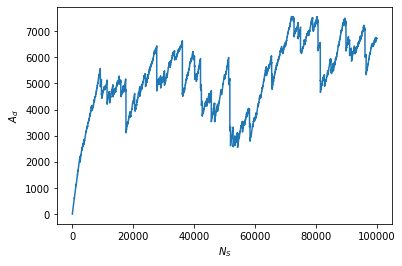

Simulation parameters: slope                          2.273643
effective_radius_multiplier    1.582490
r_stat_multiplier              3.497914
min_rim_percentage             0.550050
Name: 0, dtype: float64


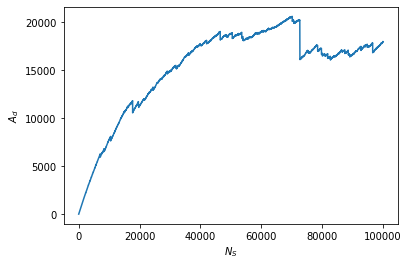

In [11]:
for x in [0, 10, 20, 30, 40, 50]:
    plot_sim_ci(model, holdout_dfs[x], metric, assembler, ivs, assembler.getInputCols())

In [12]:
# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns), sample_cadence=1)
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()

23/05/04 16:25:05 WARN TaskSetManager: Stage 26 contains a task of very large size (43621 KiB). The maximum recommended task size is 1000 KiB.


0.046512742605734486

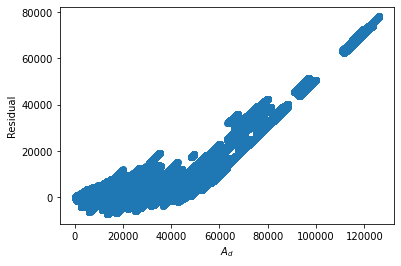

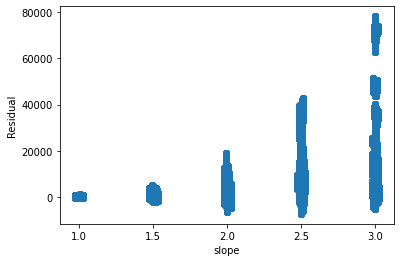

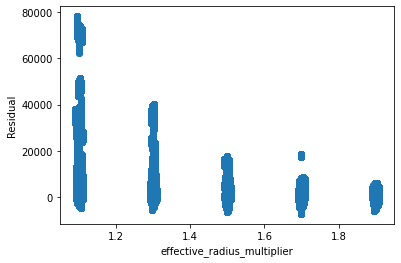

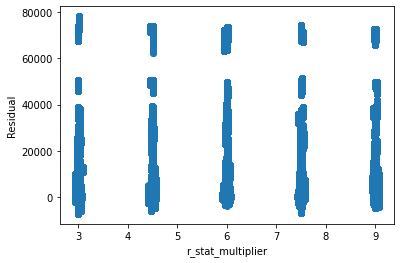

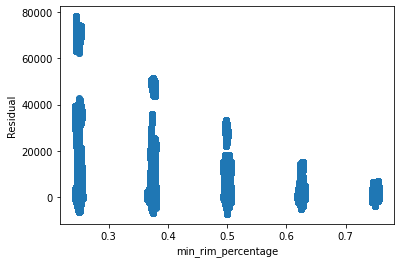

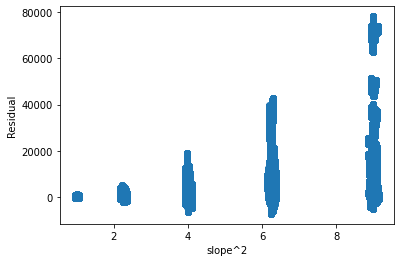

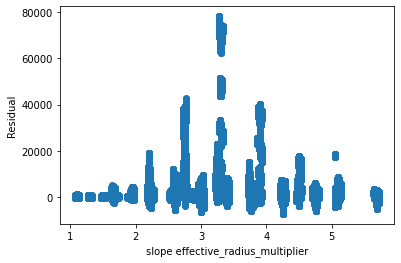

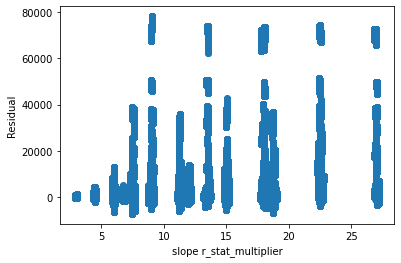

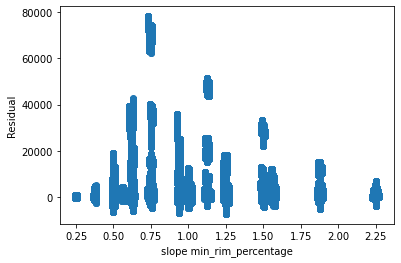

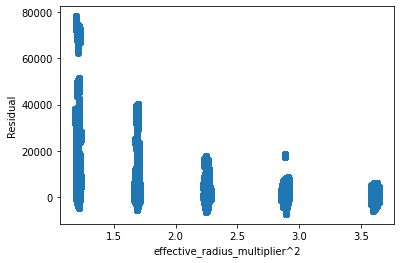

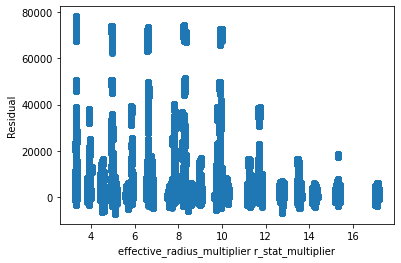

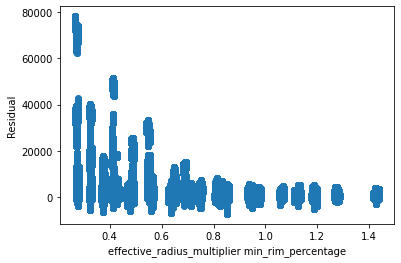

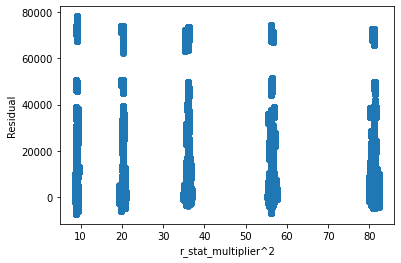

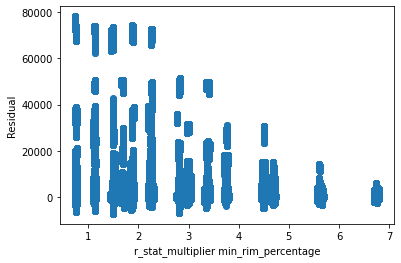

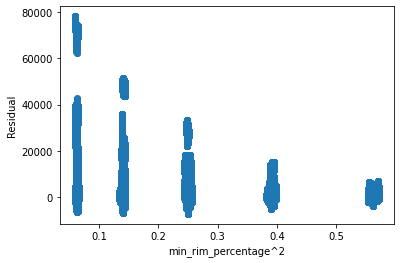

In [13]:
resid = pred_df["actual"] - pred_df["prediction"]
plt.scatter(pred_df["actual"], resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in assembler.getInputCols():
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()

In [14]:
# Metrics for all test data
all_holdout = pd.concat([x.iloc[-50000:] for x in holdout_dfs])
pred_df = score_model(model, all_holdout, metric, assembler, ivs, list(X_train.columns), sample_cadence=1)
pred_df["outside_range"] = pred_df.actual < pred_df.prediction
pred_df.outside_range.mean()

23/05/04 16:31:01 WARN TaskSetManager: Stage 27 contains a task of very large size (21296 KiB). The maximum recommended task size is 1000 KiB.


0.3052376842105263

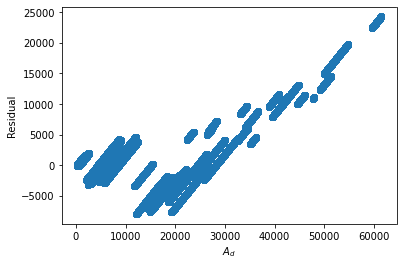

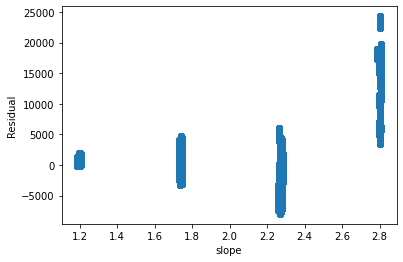

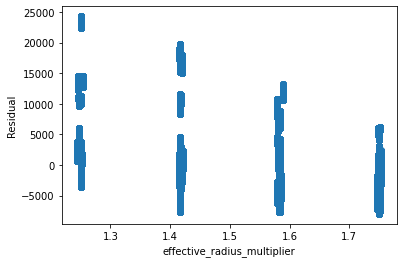

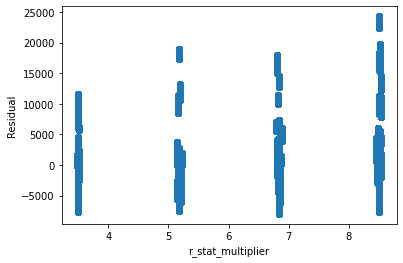

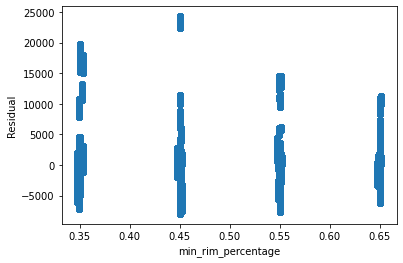

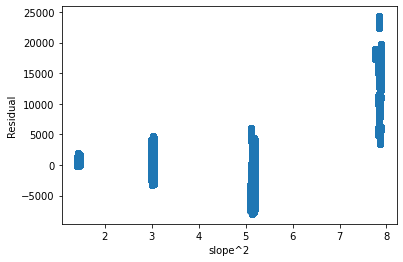

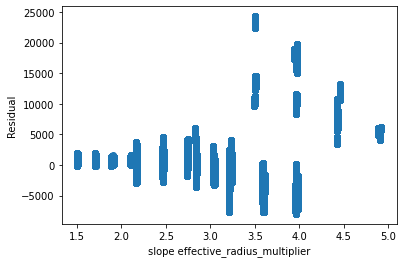

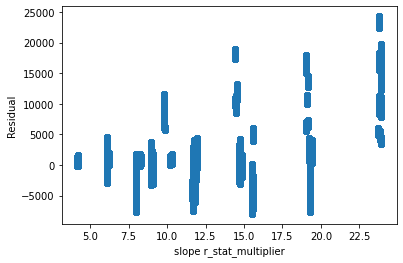

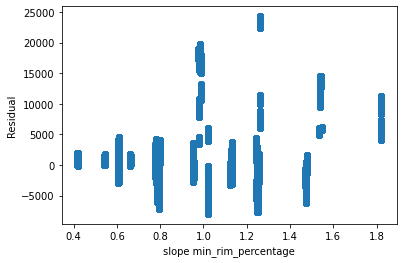

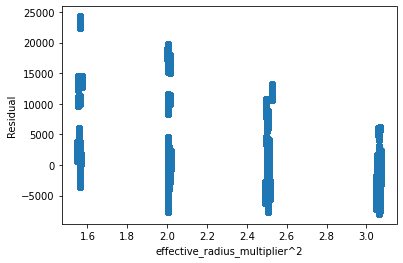

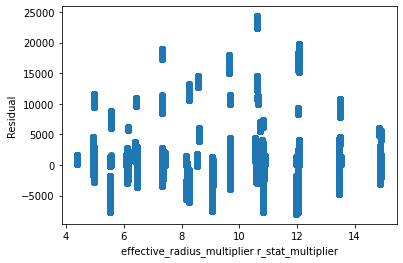

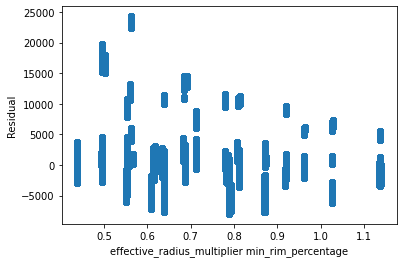

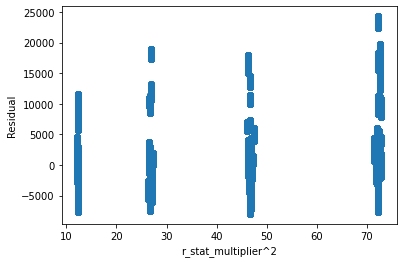

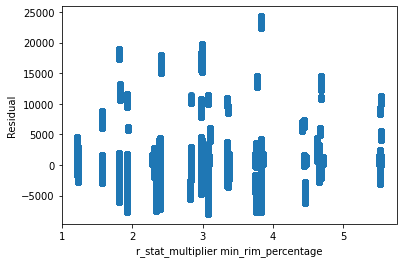

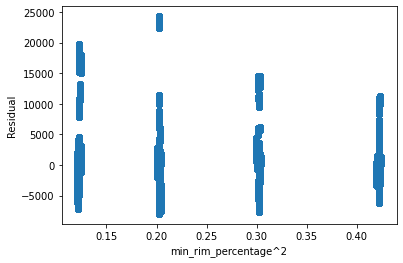

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 32776)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/mason/code/saturation/venv/lib/python3.10/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/mason/code/saturation/venv/lib/python3.10/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/mason/code/saturation/venv/lib/python3.10/site-packages/pyspark/accumulators.py", line 257

In [15]:
resid = pred_df["actual"] - pred_df["prediction"]
plt.scatter(pred_df["actual"], resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in assembler.getInputCols():
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()